---
# Melanoma Detection Case Study
---
### Objective:
- Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths.
- A solution which can evaluate images and alert the dermatologists about the **presence of melanoma** has the potential to reduce a lot of manual effort needed in diagnosis.

---
---

## Table of Content

* [Import the needed libraries](#import)
* [Import Skin Cancer Data](#import_data)
    * [Dataset Creation](#dataset_create)
    * [Dataset Visualization](#dataset_visualize)
* [Base Model building and Training](#base_model)
* [Data Augmentation](#data_augment)
    * [Base Model + Augmentation Layer](#base_augment_model)
    * [Base Model + Augmentation Layer + 1 dropout layer](#base_augment_model_1)
    * [Base Model + Augmentation Layer + more dropout layers](#base_augment_model_2)
* [Class Distribution](#class_distribution)
    * [Handling class imbalances](#handle_imbalance)
    * [Dataset creation](#dataset_create_1)
    * [Base Model + Augmentation Layer + more dropout layers](#class_imbalance_model_1)
    * [Base model + Augmentation Layer + more dropout layers + 1 batch norm layer](#class_imbalance_model_2)
    * [Base model + Augmentation Layer + more dropout layers + more batch norm layer](#class_imbalance_model_3)
    * [Base model + Augmentation Layer + more dropout layers + more batch norm layer (reposition)](#class_imbalance_model_4)
    * [Base model + Augmentation Layer + more dropout layers + more batch norm layer (Modification)](#class_imbalance_model_5)
* [Analysis on Test Data](#analysis)
    * [Prediction on test data](#analysis_predict)
    * [Conclusion](#analysis_conclusion)
---
---

<a id='import'></a>
## Import the needed libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings('ignore')

---
---
<a id='import_data'></a>
## Import Skin Cancer Data

- Set the **'use_colab'** variable to *True* in the below cell to use the colab and drive platform.

In [2]:
# Set this to True if using colab platform with drive
use_colab = True
folder_prefix = ''

if use_colab:
  # If you are using the data by mounting the google drive, use the following :
  from google.colab import drive
  drive.mount('/content/gdrive')
  folder_prefix = "/content/gdrive/MyDrive/Upgrad/MelanomaDetection/"

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(folder_prefix + "Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path(folder_prefix + "Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of Train images : ",image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Number of Test images  : ",image_count_test)

Number of Train images :  2239
Number of Test images  :  118


---
<a id='dataset_create'></a>
### Dataset creation

Define parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

#### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility with 80% of the images for training, and 20% for validation.

In [6]:
# Create train dataset here
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,image_size=(img_width,img_height),
                                                               batch_size=batch_size,validation_split=0.2,
                                                               subset='training',seed=123)
train_ds

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
# Create validation dataset here
val_ds = val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,image_size=(img_width,img_height),
                                                             batch_size=batch_size,validation_split=0.2,
                                                             subset='validation',seed=123)
val_ds

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


---
<a id='dataset_visualize'></a>
### Dataset Visualization
- Let's visualize one instance of all the nine classes present in the dataset

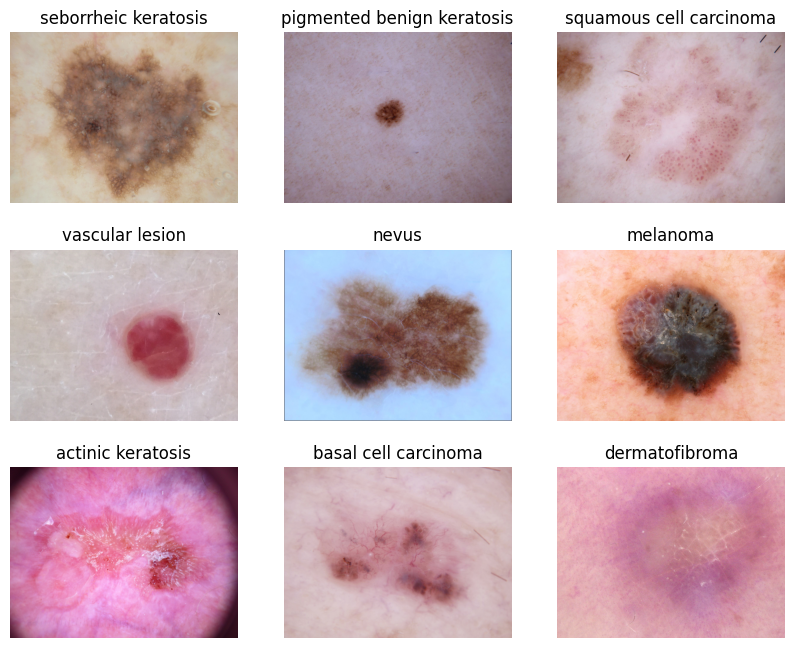

In [9]:
import matplotlib.pyplot as plt

from PIL import Image
fig=plt.figure(figsize=(10,8))
index = 1
for folder in data_dir_train.iterdir():
  im=Image.open(folder.iterdir().__next__())
  plt.subplot(3,3,index)
  plt.imshow(im)
  plt.title(str(folder).split('/')[-1])
  index+=1
  plt.axis("off")

#### Improve execution speed

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

---
---
<a id='base_model'></a>
## Base Model building and Training

- Let's create a base CNN model, which can accurately detect 9 classes present in the dataset.
- We will use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

> Let's create a helper method to visualize the train results.

In [11]:
# Visualizet the train results
def visualize_train_results(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

---
### Base Model

- Let's create and compile the base model.

In [12]:
# Model Network
base_model = Sequential([
         # Normalizing the input
         layers.Rescaling(1./255,input_shape=(img_height,img_width,3)),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128,activation="relu"),
         layers.Dense(64,activation="relu"),
         layers.Dense(num_classes)
])

# Compile the model
base_model.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

#### Train the model

In [13]:
epochs = 30

# Train the model with 30 epochs
history_base_model = base_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 181s 667ms/step - loss: 2.0653 - accuracy: 0.1964 - val_loss: 2.0567 - val_accuracy: 0.1924
Epoch 2/30
56/56 [==============================] - 1s 21ms/step - loss: 1.9140 - accuracy: 0.2812 - val_loss: 1.7903 - val_accuracy: 0.3087
Epoch 3/30
56/56 [==============================] - 1s 19ms/step - loss: 1.6777 - accuracy: 0.3845 - val_loss: 1.6047 - val_accuracy: 0.4609
Epoch 4/30
56/56 [==============================] - 1s 19ms/step - loss: 1.4637 - accuracy: 0.4883 - val_loss: 1.5973 - val_accuracy: 0.4922
Epoch 5/30
56/56 [==============================] - 1s 20ms/step - loss: 1.3492 - accuracy: 0.5340 - val_loss: 1.3563 - val_accuracy: 0.5481
Epoch 6/30
56/56 [==============================] - 1s 20ms/step - loss: 1.2939 - accuracy: 0.5419 - val_loss: 1.3799 - val_accuracy: 0.5235
Epoch 7/30
56/56 [==============================] - 1s 21ms/step - loss: 1.2052 - accuracy: 0.5848 - val_loss: 1.3524 - val_accuracy: 0.5615
Epoch 8/30

#### Visualizing training results

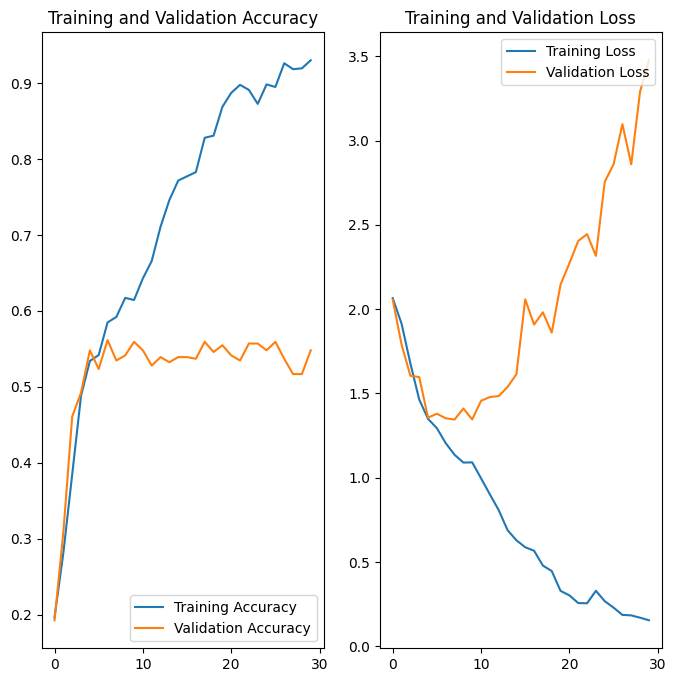

In [14]:
visualize_train_results(history_base_model)

#### Inference from Base Model:

- After *30 epochs*, training accuracy is high as *0.93* whereas validation accuracy is low as *0.54*.
- Even the training loss keeps decreasing, whereas the validation loss keeps increasing after every epoch.

> The above two observations clearly indicate that the model is *not good* and it is **overfitting**.

---
---


<a id='data_augment'></a>
## Data Augmentation
- It was evident that the base model was overfitting.
- Let's overcome the overfitting, by augmenting the data using random flip, rotation, zoom and contrast as shown below.

In [15]:
# Augmentation layers
data_augument_layers = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomContrast(0.2)
])

> - Let's visualize augmentation strategy works for one instance of training image.

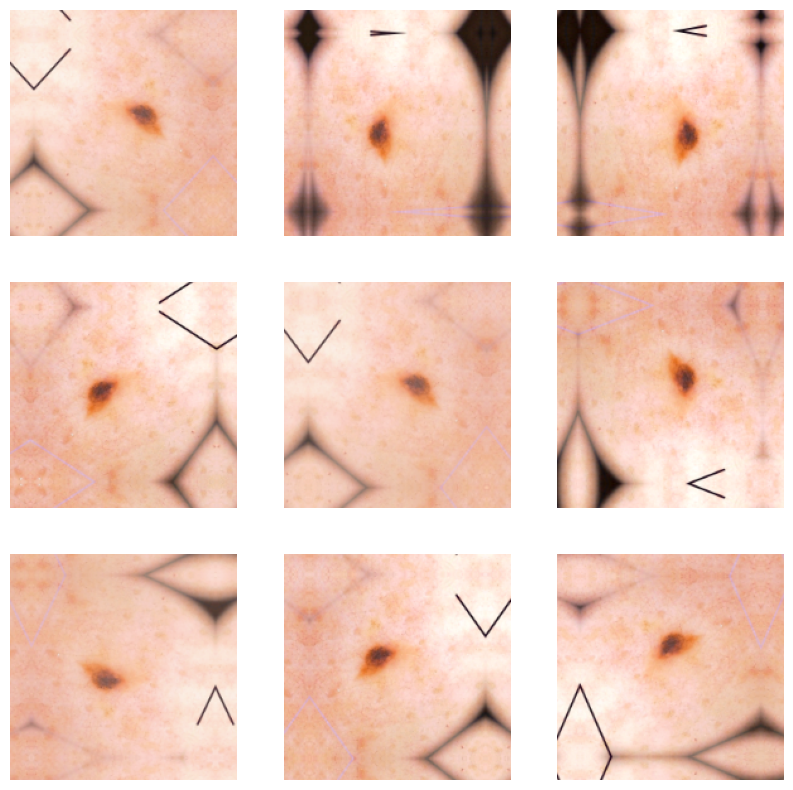

In [16]:
# Visualize the augmentation strategy
for batch,labels in train_ds.take(1):
  im=batch[0]
  im=tf.reshape(im,(1,img_width,img_height,3))

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augument_layers(im)[0]
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image.numpy().astype("uint8"))
  plt.axis("off")

---
<a id='base_augment_model'></a>
### Model building
### Base Model + Augmentation Layer

- Let's create and compile the base model with augmentation layers.

In [17]:
# Model Network
aug_model = Sequential([
         # Augmentation Layers
         data_augument_layers,

         # Normalizing the input
         layers.Rescaling(1./255),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128,activation="relu"),
         layers.Dense(64,activation="relu"),
         layers.Dense(num_classes)
])

# Compile the model
aug_model.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
aug_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

#### Train the model

In [18]:
epochs = 30

# Train the model with 30 epochs
history_aug_model = aug_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 4s 27ms/step - loss: 2.0700 - accuracy: 0.1948 - val_loss: 2.0116 - val_accuracy: 0.1678
Epoch 2/30
56/56 [==============================] - 1s 23ms/step - loss: 1.9809 - accuracy: 0.2483 - val_loss: 1.9489 - val_accuracy: 0.2640
Epoch 3/30
56/56 [==============================] - 1s 22ms/step - loss: 1.8631 - accuracy: 0.3186 - val_loss: 1.7058 - val_accuracy: 0.3557
Epoch 4/30
56/56 [==============================] - 1s 22ms/step - loss: 1.6865 - accuracy: 0.3945 - val_loss: 1.6026 - val_accuracy: 0.4295
Epoch 5/30
56/56 [==============================] - 1s 23ms/step - loss: 1.5160 - accuracy: 0.4688 - val_loss: 1.4365 - val_accuracy: 0.4944
Epoch 6/30
56/56 [==============================] - 1s 22ms/step - loss: 1.4030 - accuracy: 0.5067 - val_loss: 1.5751 - val_accuracy: 0.4586
Epoch 7/30
56/56 [==============================] - 1s 23ms/step - loss: 1.3863 - accuracy: 0.4994 - val_loss: 1.4260 - val_accuracy: 0.4832
Epoch 8/30
56

#### Visualizing the results

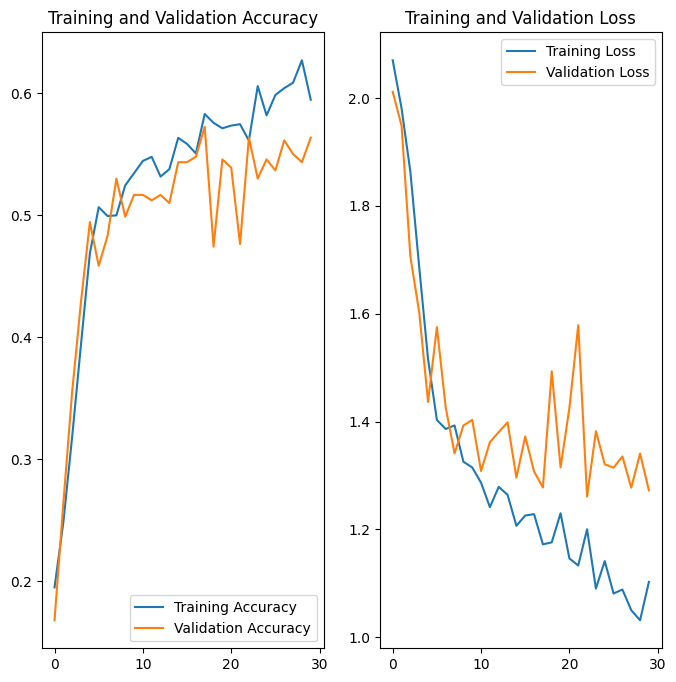

In [19]:
visualize_train_results(history_aug_model)

#### Inference from Base model + Augmentation layers :
- After *30 epochs*, we could see that training accuracy is *0.59* and validation accuracy is *0.56* which is close.
- From the accuracy and loss plots, we could see that validation accuracy and validation loss starts saturating after some epochs. This means that there is still **some extent of overfitting** though much better than the base model.
> This proves that the model due to the *addition of augmentation layers* have reduced the overfitting by *large extent*.

---
<a id='base_augment_model_1'></a>
### Base Model + Augmentation Layer + 1 dropout layer
- Let's add one drop out layer to see if there is any improvement.

In [20]:
# Model Network
aug_dropout_model_1 = Sequential([
         # Augmentation Layers
         data_augument_layers,

         # Normalizing the input
         layers.Rescaling(1./255),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128,activation="relu"),
         layers.Dense(64,activation="relu"),
         layers.Dense(num_classes)
])

# Compile the model
aug_dropout_model_1.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
aug_dropout_model_1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

#### Training the model

In [21]:
epochs = 30

# Train the model for 30 epochs
history_aug_dropout_1 = aug_dropout_model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 6s 34ms/step - loss: 1.9859 - accuracy: 0.2573 - val_loss: 1.9638 - val_accuracy: 0.2528
Epoch 2/30
56/56 [==============================] - 2s 29ms/step - loss: 1.7377 - accuracy: 0.3616 - val_loss: 1.5620 - val_accuracy: 0.4541
Epoch 3/30
56/56 [==============================] - 2s 29ms/step - loss: 1.5705 - accuracy: 0.4397 - val_loss: 1.4712 - val_accuracy: 0.4899
Epoch 4/30
56/56 [==============================] - 2s 29ms/step - loss: 1.4291 - accuracy: 0.5006 - val_loss: 1.4446 - val_accuracy: 0.5056
Epoch 5/30
56/56 [==============================] - 2s 29ms/step - loss: 1.4471 - accuracy: 0.4927 - val_loss: 1.5239 - val_accuracy: 0.4541
Epoch 6/30
56/56 [==============================] - 2s 32ms/step - loss: 1.4311 - accuracy: 0.4916 - val_loss: 1.4973 - val_accuracy: 0.4810
Epoch 7/30
56/56 [==============================] - 2s 30ms/step - loss: 1.3620 - accuracy: 0.5290 - val_loss: 1.4501 - val_accuracy: 0.4989
Epoch 8/30
56

#### Visualizing the results

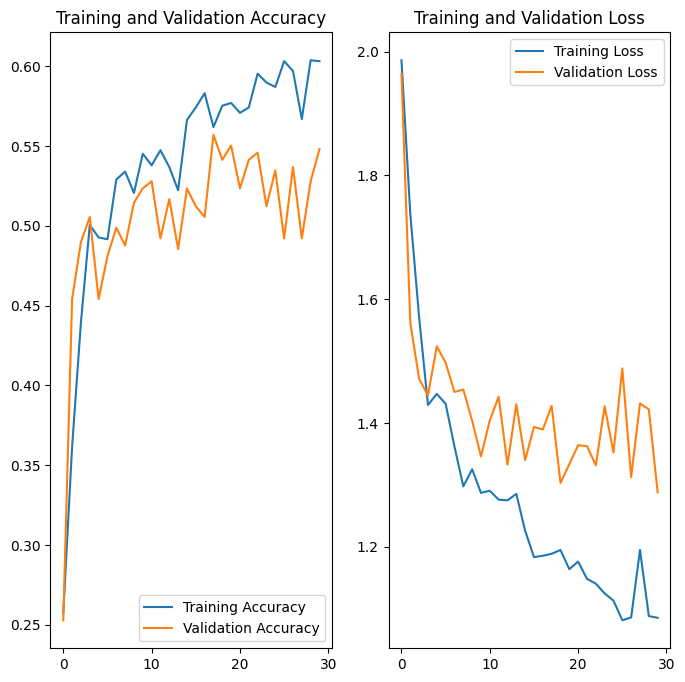

In [22]:
visualize_train_results(history_aug_dropout_1)

#### Inference from Base Model + Augmentation Layer + 1 dropout layer:

- After *30 epochs*, we can see that by adding one dropout layer, training accuracy changed by a negligible value to *0.60* and validation accuracy to *0.54*.
- From the accuracy and loss plots, we could see that the training and validation results are *trying to overlap*.
> This proves that *addition of one dropout layer* have reduced negligible amount of overfitting.

---
<a id='base_augment_model_2'></a>
### Base Model + Augmentation Layer + more dropout layers
- Let's add more dropout layers and experiment.

In [23]:
# Model Network
aug_dropout_model_2 = Sequential([
         # Augmentation Layers
         data_augument_layers,

         # Normalizing the input
         layers.Rescaling(1./255),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128,activation="relu"),
         # Dropout layer
         layers.Dropout(0.2),
         layers.Dense(64,activation="relu"),
         layers.Dense(num_classes)
])

# Compile the model
aug_dropout_model_2.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
aug_dropout_model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

#### Training the model

In [24]:
epochs = 30

# Train the model with 30 epochs
history_aug_dropout_2 = aug_dropout_model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 4s 38ms/step - loss: 2.0930 - accuracy: 0.2054 - val_loss: 2.0137 - val_accuracy: 0.3356
Epoch 2/30
56/56 [==============================] - 2s 33ms/step - loss: 1.8356 - accuracy: 0.3125 - val_loss: 1.6806 - val_accuracy: 0.3826
Epoch 3/30
56/56 [==============================] - 2s 31ms/step - loss: 1.6946 - accuracy: 0.4096 - val_loss: 1.6818 - val_accuracy: 0.4161
Epoch 4/30
56/56 [==============================] - 2s 31ms/step - loss: 1.6328 - accuracy: 0.4152 - val_loss: 1.5168 - val_accuracy: 0.4877
Epoch 5/30
56/56 [==============================] - 2s 30ms/step - loss: 1.5778 - accuracy: 0.4425 - val_loss: 1.5153 - val_accuracy: 0.4631
Epoch 6/30
56/56 [==============================] - 2s 31ms/step - loss: 1.5343 - accuracy: 0.4492 - val_loss: 1.5145 - val_accuracy: 0.5034
Epoch 7/30
56/56 [==============================] - 2s 33ms/step - loss: 1.4853 - accuracy: 0.4715 - val_loss: 1.5160 - val_accuracy: 0.4855
Epoch 8/30
56

#### Visualizing the results

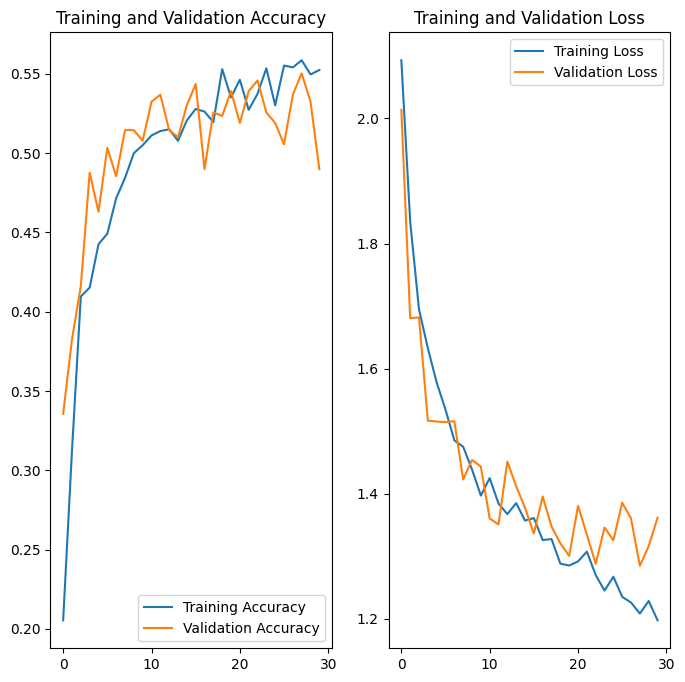

In [25]:
visualize_train_results(history_aug_dropout_2)

#### Inference from Base Model + Augmentation Layer + more dropout layers:

- After *30 epochs*, we can see that by adding more dropout layers, training accuracy dropped to *0.55* and validation accuracy is *0.48*.
- From the accuracy and loss plots, we could see that the training and validation results are *almost overlapping*.
> This proves that *addition of more dropout layers* have reduced the overfitting.

We can also see there is no further improvement in accuracy due to lack of data. Let's try to *generate* more data for each class.

---
---


<a id='class_distribution'></a>
## Class Distribution

- Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
# Visualize the class distribution
data_detail_pd = pd.DataFrame(columns=["Dir_Name","Total Image(Train)","Total Percentage(Train)","Total Image(Test)","Total Percentage(Test)"])

dir_train = os.listdir(data_dir_train)
dir_test = os.listdir(data_dir_test)

for dir_name in dir_train:
   total_image_in_folder = len(list(data_dir_train.glob(dir_name+"/*.jpg")))
   df = {"Dir_Name":dir_name,"Total Image(Train)":total_image_in_folder,"Total Percentage(Train)":round((total_image_in_folder/image_count_train)*100,2)}
   data_detail_pd = data_detail_pd.append(df,ignore_index=True)

data_detail_pd = data_detail_pd.set_index("Dir_Name")

for dir_name in dir_test:
   total_image_in_folder = len(list(data_dir_test.glob(dir_name+"/*.jpg")))
   data_detail_pd.loc[dir_name,"Total Image(Test)"]  = total_image_in_folder
   data_detail_pd.loc[dir_name,"Total Percentage(Test)"]  = round((total_image_in_folder/image_count_test)*100,2)

display(data_detail_pd.sort_values(by="Total Percentage(Train)",ascending=False))

,Total Image(Train),Total Percentage(Train),Total Image(Test),Total Percentage(Test)
Dir_Name,,,,
pigmented benign keratosis,462,20.63,16,13.56
melanoma,438,19.56,16,13.56
basal cell carcinoma,376,16.79,16,13.56
nevus,357,15.94,16,13.56
squamous cell carcinoma,181,8.08,16,13.56
vascular lesion,139,6.21,3,2.54
actinic keratosis,114,5.09,16,13.56
dermatofibroma,95,4.24,16,13.56
seborrheic keratosis,77,3.44,3,2.54


#### - Which class has the least number of samples?
- **Seborrheic keratosis** has 77 images contributing to only *3.44%* of training data.

#### - Which classes dominate the data in terms proportionate number of samples?
- **Pigmented benign keratosis** has 462 images contributing to *20.63%* of training data.

---

<a id='handle_imbalance'></a>
### Handling class imbalances
> - We use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset=str(data_dir_train)+'/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5704C37D60>: 100%|██████████| 500/500 [00:22<00:00, 21.94 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C5704EC3F10>: 100%|██████████| 500/500 [00:22<00:00, 22.69 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C5704C6BDC0>: 100%|██████████| 500/500 [00:21<00:00, 23.40 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7C5704C19CC0>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C57106E97B0>: 100%|██████████| 500/500 [01:16<00:00,  6.55 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C5704D944C0>: 100%|██████████| 500/500 [00:18<00:00, 27.30 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C5704E88400>: 100%|██████████| 500/500 [00:39<00:00, 12.67 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C57703C5180>: 100%|██████████| 500/500 [00:18<00:00, 27.78 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Upgrad/MelanomaDetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C577052E1D0>: 100%|██████████| 500/500 [00:18<00:00, 27.27 Samples/s]


> - Augmentor has stored the augmented images in the **output** sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Number of Train images : ",image_count_train)

aug_image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print("Number of additional images after augmenting : ",aug_image_count_train)

total_image_count_train = image_count_train + aug_image_count_train
print("Number of Train images after augmenting : ",total_image_count_train)

Number of Train images :  2239
Number of additional images after augmenting :  4500
Number of Train images after augmenting :  6739


#### Lets see the class distribution of augmented data after adding new images to the original training data.

In [30]:
for dir_name in dir_train:
   total_image_in_folder = len(list(data_dir_train.glob(dir_name+"/*.jpg"))) + len(list(data_dir_train.glob(dir_name+"/output/*.jpg")))
   data_detail_pd.loc[dir_name,"Total Image(Train)"]  = total_image_in_folder
   data_detail_pd.loc[dir_name,"Total Percentage(Train)"]  = round((total_image_in_folder/total_image_count_train)*100,2)
data_detail_pd

,Total Image(Train),Total Percentage(Train),Total Image(Test),Total Percentage(Test)
Dir_Name,,,,
seborrheic keratosis,577,8.56,3,2.54
pigmented benign keratosis,962,14.28,16,13.56
squamous cell carcinoma,681,10.11,16,13.56
vascular lesion,639,9.48,3,2.54
nevus,857,12.72,16,13.56
melanoma,938,13.92,16,13.56
actinic keratosis,614,9.11,16,13.56
basal cell carcinoma,876,13.00,16,13.56
dermatofibroma,595,8.83,16,13.56


> - So, now we have added 500 images to all the classes to maintain some class balance.

---
<a id='dataset_create_1'></a>
### Dataset creation

In [31]:
# Create a training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)
train_ds

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [32]:
# Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [33]:
# AutoTune & cache for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

---

### Model Building
<a id='class_imbalance_model_1'></a>
### Base Model + Augmentation Layer + more dropout layers

- Let's retrain the Base Model + Augmentation Layer + more dropout layers with the new dataset.

In [34]:
# Model Network same as Base Model + Augmentation Layer + more dropout layers
class_balanced_model_1 = Sequential([
         # Augmentation Layers
         data_augument_layers,

         # Normalizing the input
         layers.Rescaling(1./255),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128,activation="relu"),
         # Dropout layer
         layers.Dropout(0.2),
         layers.Dense(64,activation="relu"),
         layers.Dense(num_classes)
])

# Compile the model
class_balanced_model_1.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
class_balanced_model_1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

#### Training the model

In [35]:
epochs = 30

# Train the model with 30 epochs
history_class_balanced_1 = class_balanced_model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 53s 78ms/step - loss: 1.9317 - accuracy: 0.2446 - val_loss: 1.6564 - val_accuracy: 0.3682
Epoch 2/30
169/169 [==============================] - 6s 33ms/step - loss: 1.6138 - accuracy: 0.3824 - val_loss: 1.5418 - val_accuracy: 0.4269
Epoch 3/30
169/169 [==============================] - 6s 33ms/step - loss: 1.5215 - accuracy: 0.4149 - val_loss: 1.4602 - val_accuracy: 0.4484
Epoch 4/30
169/169 [==============================] - 6s 34ms/step - loss: 1.4629 - accuracy: 0.4332 - val_loss: 1.3964 - val_accuracy: 0.4373
Epoch 5/30
169/169 [==============================] - 5s 30ms/step - loss: 1.4286 - accuracy: 0.4494 - val_loss: 1.4880 - val_accuracy: 0.4239
Epoch 6/30
169/169 [==============================] - 5s 32ms/step - loss: 1.4092 - accuracy: 0.4601 - val_loss: 1.2675 - val_accuracy: 0.4944
Epoch 7/30
169/169 [==============================] - 5s 31ms/step - loss: 1.3481 - accuracy: 0.4796 - val_loss: 1.3836 - val_accuracy: 0.461

#### Visualizing the model results

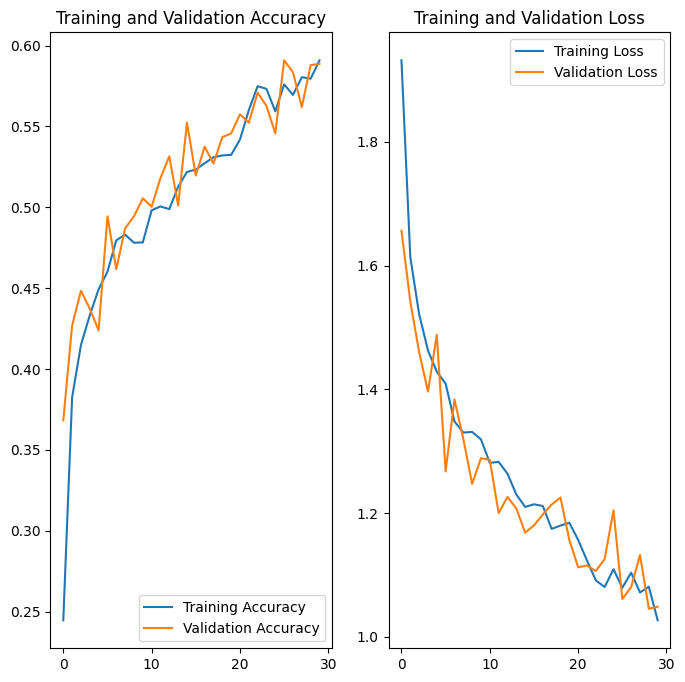

In [36]:
visualize_train_results(history_class_balanced_1)

#### Inference from Base model + Augmentation Layer + more dropout layers:
- After *30 epochs*, we could see the training accuracy to be *0.59* and validation accuracy to be *0.58*.
- From the accuracy and loss plots, we could see that the training and validation results are overlapping and in some epochs, the model showcased underfitting.

>  Let's improve the accuracy by adding one batch normalization layer.

---
<a id='class_imbalance_model_2'></a>
### Base model + Augmentation Layer + more dropout layers + 1 batch norm layer

In [37]:
# Model Network
class_balanced_model_2 = Sequential([
         # Augmentation Layers
         data_augument_layers,

         # Normalizing the input
         layers.Rescaling(1./255),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Batch normalization layer
         layers.BatchNormalization(),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128,activation="relu"),
         # Dropout layer
         layers.Dropout(0.2),
         layers.Dense(64,activation="relu"),
         layers.Dense(num_classes)
])

# Compile the model
class_balanced_model_2.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
class_balanced_model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization (Batch  (None, 90, 90, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)       

#### Training the model

In [38]:
epochs = 30

# Train the model with 30 epochs
history_class_balanced_2 = class_balanced_model_2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 8s 33ms/step - loss: 1.8015 - accuracy: 0.3242 - val_loss: 2.1482 - val_accuracy: 0.2138
Epoch 2/30
169/169 [==============================] - 6s 34ms/step - loss: 1.5192 - accuracy: 0.4299 - val_loss: 1.8848 - val_accuracy: 0.3497
Epoch 3/30
169/169 [==============================] - 6s 33ms/step - loss: 1.4339 - accuracy: 0.4529 - val_loss: 1.6341 - val_accuracy: 0.3868
Epoch 4/30
169/169 [==============================] - 6s 34ms/step - loss: 1.3685 - accuracy: 0.4779 - val_loss: 1.4061 - val_accuracy: 0.4937
Epoch 5/30
169/169 [==============================] - 6s 34ms/step - loss: 1.3118 - accuracy: 0.5000 - val_loss: 1.4475 - val_accuracy: 0.4328
Epoch 6/30
169/169 [==============================] - 6s 33ms/step - loss: 1.2994 - accuracy: 0.4976 - val_loss: 1.7096 - val_accuracy: 0.3860
Epoch 7/30
169/169 [==============================] - 6s 36ms/step - loss: 1.2313 - accuracy: 0.5230 - val_loss: 1.4313 - val_accuracy: 0.4284

#### Visualizing the model results

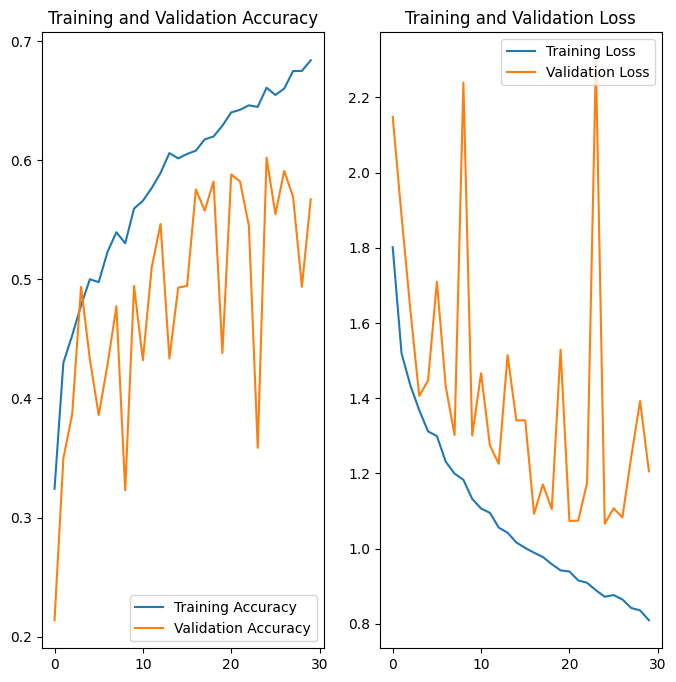

In [39]:
visualize_train_results(history_class_balanced_2)

#### Inference from Base model +  Augmentation Layer + more dropout layers + 1 batch norm layer:
- After *30 epochs*, we could see the training accuracy to be *0.68* and validation accuracy to be *0.56*.
- From the accuracy and loss plots, we could see that the validation results are more dynamic.

>  Let's experiment by adding more batch normalization layers.

---
<a id='class_imbalance_model_3'></a>
### Base model + Augmentation Layer + more dropout layers + more batch norm layer

In [40]:
# Model Network
class_balanced_model_3 = Sequential([
         # Augmentation Layers
         data_augument_layers,

         # Normalizing the input
         layers.Rescaling(1./255),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Batch normalization layer
         layers.BatchNormalization(),
         # Dropout layer
         layers.Dropout(0.2),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Batch normalization layer
         layers.BatchNormalization(),
         # Dropout layer
         layers.Dropout(0.2),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Batch normalization layer
         layers.BatchNormalization(),
         # Dropout layer
         layers.Dropout(0.2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128,activation="relu"),
         # Batch normalization layer
         layers.BatchNormalization(),
         # Dropout layer
         layers.Dropout(0.2),

         layers.Dense(64,activation="relu"),
         # Batch normalization layer
         layers.BatchNormalization(),
         # Dropout layer
         layers.Dropout(0.2),

         layers.Dense(num_classes)
])

# Compile the model
class_balanced_model_3.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
class_balanced_model_3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_1 (Bat  (None, 90, 90, 16)        64        
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 90, 90, 16)       

#### Training the model

In [41]:
epochs = 30

# Train the model with 30 epochs
history_class_balanced_3 = class_balanced_model_3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 11s 39ms/step - loss: 1.8650 - accuracy: 0.3433 - val_loss: 3.1912 - val_accuracy: 0.1759
Epoch 2/30
169/169 [==============================] - 6s 36ms/step - loss: 1.5471 - accuracy: 0.4240 - val_loss: 2.5559 - val_accuracy: 0.1715
Epoch 3/30
169/169 [==============================] - 6s 35ms/step - loss: 1.4309 - accuracy: 0.4594 - val_loss: 2.0404 - val_accuracy: 0.2873
Epoch 4/30
169/169 [==============================] - 6s 38ms/step - loss: 1.3585 - accuracy: 0.4824 - val_loss: 2.3735 - val_accuracy: 0.2294
Epoch 5/30
169/169 [==============================] - 6s 36ms/step - loss: 1.3223 - accuracy: 0.4996 - val_loss: 1.5188 - val_accuracy: 0.3801
Epoch 6/30
169/169 [==============================] - 6s 38ms/step - loss: 1.2570 - accuracy: 0.5213 - val_loss: 1.7131 - val_accuracy: 0.3504
Epoch 7/30
169/169 [==============================] - 6s 35ms/step - loss: 1.2288 - accuracy: 0.5295 - val_loss: 1.2858 - val_accuracy: 0.498

#### Visualizing the model results

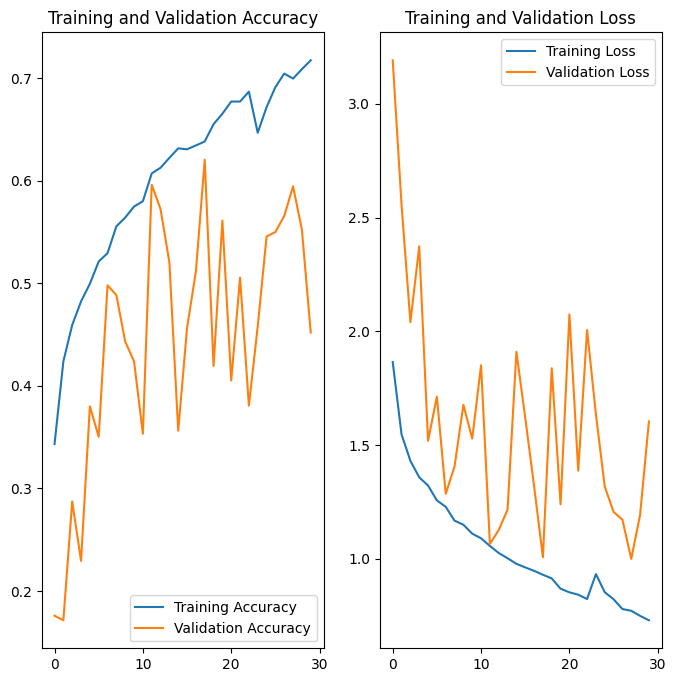

In [42]:
visualize_train_results(history_class_balanced_3)

#### Inference from Base model + Augmentation Layer + more dropout layers + more batch norm layer:
- After *30 epochs*, we could see the training accuracy to be *0.71* and validation accuracy to be *0.45*.
- From the accuracy and loss plots, we could see that the validation results are more dynamic but still the training accuracy has improved.

>  Let's experiment by repositioning the batch normalization layers.

---
<a id='class_imbalance_model_4'></a>
### Base model + Augmentation Layer + more dropout layers + more batch norm layer (reposition)

In [43]:
# Model Network
class_balanced_model_4 = Sequential([
         # Augmentation Layers
         data_augument_layers,

         # Normalizing the input
         layers.Rescaling(1./255),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same'),
         layers.BatchNormalization(),
         layers.Activation('relu'),
         layers.MaxPool2D((2,2),strides=2),
         layers.Dropout(0.2),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same'),
         layers.BatchNormalization(),
         layers.Activation('relu'),
         layers.MaxPool2D((2,2),strides=2),
         layers.Dropout(0.2),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same'),
         layers.BatchNormalization(),
         layers.Activation('relu'),
         layers.MaxPool2D((2,2),strides=2),
         layers.Dropout(0.2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128),
         layers.BatchNormalization(),
         layers.Activation('relu'),
         layers.Dropout(0.2),

         layers.Dense(64,activation="relu"),
         layers.BatchNormalization(),
         layers.Activation('relu'),
         layers.Dropout(0.2),

         layers.Dense(num_classes)
])

# Compile the model
class_balanced_model_4.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
class_balanced_model_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 batch_normalization_6 (Bat  (None, 180, 180, 16)      64        
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                

#### Training the model

In [44]:
epochs = 50

# Train the model with 50 epochs
history_class_balanced_4 = class_balanced_model_4.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 13s 53ms/step - loss: 1.9303 - accuracy: 0.3045 - val_loss: 2.6325 - val_accuracy: 0.1284
Epoch 2/50
169/169 [==============================] - 9s 51ms/step - loss: 1.5488 - accuracy: 0.4240 - val_loss: 2.4546 - val_accuracy: 0.1329
Epoch 3/50
169/169 [==============================] - 8s 48ms/step - loss: 1.4374 - accuracy: 0.4575 - val_loss: 1.8622 - val_accuracy: 0.3133
Epoch 4/50
169/169 [==============================] - 8s 50ms/step - loss: 1.3459 - accuracy: 0.4848 - val_loss: 1.8018 - val_accuracy: 0.3140
Epoch 5/50
169/169 [==============================] - 9s 52ms/step - loss: 1.2881 - accuracy: 0.5154 - val_loss: 1.4442 - val_accuracy: 0.4566
Epoch 6/50
169/169 [==============================] - 8s 48ms/step - loss: 1.2489 - accuracy: 0.5317 - val_loss: 2.1480 - val_accuracy: 0.2918
Epoch 7/50
169/169 [==============================] - 9s 50ms/step - loss: 1.2263 - accuracy: 0.5308 - val_loss: 1.4901 - val_accuracy: 0.455

#### Visualizing the model results

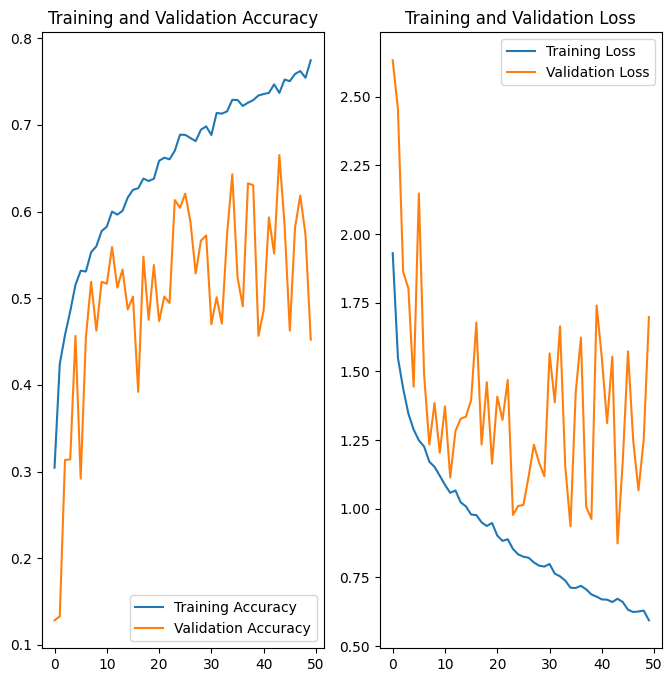

In [45]:
visualize_train_results(history_class_balanced_4)

#### Inference from Base model + Augmentation Layer + more dropout layers + more batch norm layer (Reposition):
- After *50 epochs*, we could see the training accuracy to be *0.77* and validation accuracy to be *0.45*.
- From the accuracy and loss plots, we could see that the validation results are more dynamic and there is no much change compared to the previous model.

>  Let's experiment by modifying the layers

---

<a id='class_imbalance_model_5'></a>
### Base model + Augmentation Layer + more dropout layers + more batch norm layer (Modification)

In [51]:
# Model Network
class_balanced_model_5 = Sequential([
         # Augmentation Layers
         data_augument_layers,

         # Normalizing the input
         layers.Rescaling(1./255),

         # First Conv Unit
         layers.Conv2D(16,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Batch normalization layer
         layers.BatchNormalization(),

         # Second Conv Unit
         layers.Conv2D(32,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Batch normalization layer
         layers.BatchNormalization(),

         # Third Conv Unit
         layers.Conv2D(64,3,padding='same',activation="relu"),
         layers.MaxPool2D((2,2),strides=2),
         # Dropout layer
         layers.Dropout(0.2),

         # Flatten
         layers.Flatten(),

         # Dense networks to classify the input
         layers.Dense(128,activation="relu"),
         # Batch normalization layer
         layers.BatchNormalization(),

         layers.Dense(64,activation="relu"),
         # Dropout layer
         layers.Dropout(0.2),

         layers.Dense(num_classes)
])

# Compile the model
class_balanced_model_5.compile(optimizer = 'adam',
              loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# View the summary of all layers
class_balanced_model_5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_11 (Ba  (None, 90, 90, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 32)       

#### Training the model

In [52]:
epochs = 30

# Train the model with 30 epochs
history_class_balanced_5 = class_balanced_model_5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 9s 34ms/step - loss: 1.6646 - accuracy: 0.3809 - val_loss: 2.3108 - val_accuracy: 0.1255
Epoch 2/30
169/169 [==============================] - 6s 33ms/step - loss: 1.3972 - accuracy: 0.4679 - val_loss: 1.9989 - val_accuracy: 0.2814
Epoch 3/30
169/169 [==============================] - 5s 32ms/step - loss: 1.3021 - accuracy: 0.5028 - val_loss: 1.6534 - val_accuracy: 0.3905
Epoch 4/30
169/169 [==============================] - 6s 36ms/step - loss: 1.2399 - accuracy: 0.5351 - val_loss: 1.2825 - val_accuracy: 0.4952
Epoch 5/30
169/169 [==============================] - 5s 32ms/step - loss: 1.1688 - accuracy: 0.5569 - val_loss: 1.4720 - val_accuracy: 0.4388
Epoch 6/30
169/169 [==============================] - 6s 34ms/step - loss: 1.1235 - accuracy: 0.5734 - val_loss: 1.1220 - val_accuracy: 0.5561
Epoch 7/30
169/169 [==============================] - 6s 33ms/step - loss: 1.1017 - accuracy: 0.5844 - val_loss: 1.2751 - val_accuracy: 0.5122

#### Visualizing the model results

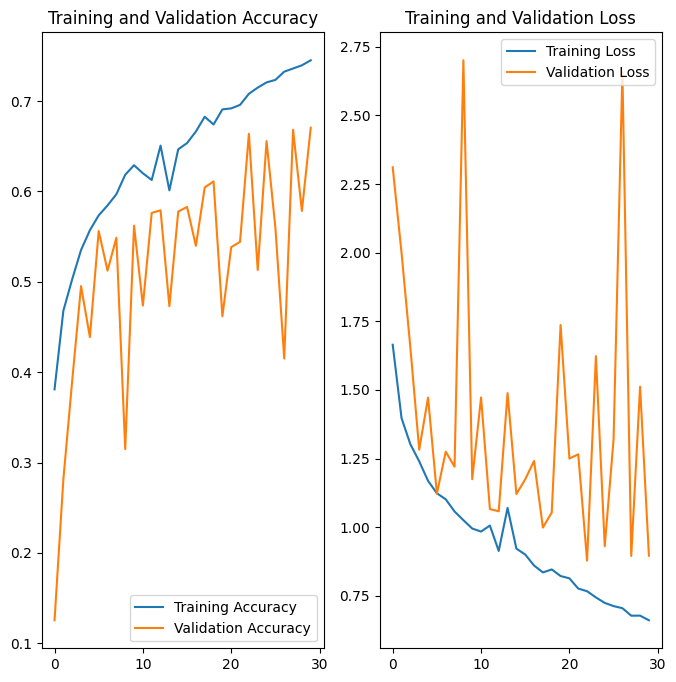

In [53]:
visualize_train_results(history_class_balanced_5)

#### Inference from  Base model + Augmentation Layer + more dropout layers + more batch norm layer (Modification)
- After *30 epochs*, we could see the training accuracy to be *0.74* and validation accuracy to be *0.67*.
- This model looks to be **good** since the *metrics* are *high* as well as the *overfitting* is *less*.
---
---
<a id='analysis'></a>
## Analysis on Test Data

> We have built 9 models, let's evaluate these models using unseen test data.

### Test dataset creation

In [46]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed = 123,
    image_size = (img_height,img_width),
    batch_size = batch_size
)

Found 118 files belonging to 9 classes.


<a id='analysis_predict'></a>
### Prediction on test data

In [74]:
# Helper method to evaulate the model on the provided data and return accuracy
def evaluate_accuracy(model, data):
  loss , accuracy = model.evaluate(data)
  return accuracy

# Dictionary of models and the report of the training results
model_dict = {
    "Base Model" : [base_model, history_base_model],
    "Base Model + Augmentation Layer" : [aug_model, history_aug_model],
    "Base Model + Augmentation Layer + 1 dropout layer" : [aug_dropout_model_1, history_aug_dropout_1],
    "Base Model + Augmentation Layer + more dropout layers" : [aug_dropout_model_2, history_aug_dropout_2],
    "Base Model + Augmentation Layer + more dropout layers with Class balance" : [class_balanced_model_1, history_class_balanced_1],
    "Base model + Augmentation Layer + more dropout layers + 1 batch norm layer with Class balance" : [class_balanced_model_2, history_class_balanced_2],
    "Base model + Augmentation Layer + more dropout layers + more batch norm layer with Class balance" : [class_balanced_model_3, history_class_balanced_3],
    "Base model + Augmentation Layer + more dropout layers + more batch norm layer (reposition) with Class balance" : [class_balanced_model_4, history_class_balanced_4],
    "Base model + Augmentation Layer + more dropout layers + more batch norm layer (Modification) with Class balance" : [class_balanced_model_5, history_class_balanced_5]
}

# Report dataframe
report_df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy'])

# Run through the list of models to generate the report
for key, items in model_dict.items():
  df = {'Model' : key,  # Model name
        'Train Accuracy'     : round(items[1].history['accuracy'][-1],2),     # Get the accuracy of training data at the last epoch
        'Validation Accuracy': round(items[1].history['val_accuracy'][-1],2), # Get the accuracy of validation data at the last epoch
        'Test Accuracy'      : round(evaluate_accuracy(items[0], test_ds),2)} # Get the accuracy of test data using the trained model
  report_df = report_df.append(df, ignore_index=True)

# Display the report
display(report_df.sort_values(by=['Test Accuracy'], ascending=False))

4/4 [==============================] - 4s 13ms/step - loss: 2.2128 - accuracy: 0.5339


,Model,Train Accuracy,Validation Accuracy,Test Accuracy
8,Base model + Augmentation Layer + more dropout...,0.74,0.67,0.53
5,Base model + Augmentation Layer + more dropout...,0.68,0.57,0.45
2,Base Model + Augmentation Layer + 1 dropout layer,0.60,0.55,0.42
4,Base Model + Augmentation Layer + more dropout...,0.59,0.59,0.42
6,Base model + Augmentation Layer + more dropout...,0.72,0.45,0.39
1,Base Model + Augmentation Layer,0.59,0.56,0.38
3,Base Model + Augmentation Layer + more dropout...,0.55,0.49,0.32
7,Base model + Augmentation Layer + more dropout...,0.77,0.45,0.30
0,Base Model,0.93,0.55,0.29


<a id='analysis_conclusion'></a>
### Conclusion

|index|Model|Train Accuracy|Validation Accuracy|Test Accuracy|
|---|---|---|---|---|
|8|Base model + Augmentation Layer + more dropout layers + more batch norm layer \(Modification\) with Class balance|0\.74|0\.67|0\.53|
|5|Base model + Augmentation Layer + more dropout layers + 1 batch norm layer with Class balance|0\.68|0\.57|0\.45|
|2|Base Model + Augmentation Layer + 1 dropout layer|0\.6|0\.55|0\.42|
|4|Base Model + Augmentation Layer + more dropout layers with Class balance|0\.59|0\.59|0\.42|
|6|Base model + Augmentation Layer + more dropout layers + more batch norm layer with Class balance|0\.72|0\.45|0\.39|
|1|Base Model + Augmentation Layer|0\.59|0\.56|0\.38|
|3|Base Model + Augmentation Layer + more dropout layers|0\.55|0\.49|0\.32|
|7|Base model + Augmentation Layer + more dropout layers + more batch norm layer \(reposition\) with Class balance|0\.77|0\.45|0\.3|
|0|Base Model|0\.93|0\.55|0\.29|

- From the above report, we could see that the class balance and augmentation strategy works well.
- The best metrics got from this experiment is *Train accuracy* of **0.74**, *Validation Accuracy* of **0.67** and *Test Accuracy* of **0.53**.

---
---